In [2]:
import polars as pl
import numpy as np
import torch
import math
import time
import heapq
from typing import List
import tqdm

In [3]:
def convert_to_cartesian(distances, ra, dec):
    x = distances * torch.cos(dec) * torch.cos(ra)
    y = distances * torch.cos(dec) * torch.sin(ra)
    z = distances * torch.sin(dec)
    return torch.stack((x, y, z), dim=1)

def calculate_distances(coords):
    dist_matrix = torch.cdist(coords, coords)
    unique_distances = torch.unique(dist_matrix)
    return unique_distances[unique_distances > 0]

def distance_from_magnitude(m, M):
    return 10**((m - M + 5) / 5)

def distance_from_magnitude_tensor(m: torch.Tensor, M: torch.Tensor) -> torch.Tensor:
    return 10**((m - M + 5) / 5)

# one of the possibilities
def tetrahedron_score(coords):
    distances = calculate_distances(coords)
    print(distances)
    mean_distance = torch.mean(distances)
    std_dev = torch.std(distances)

    # Assuming std_dev is small enough, the score will be close to 1
    # Otherwise, it will be closer to 0
    score = math.exp(-std_dev.item() / mean_distance.item())
    return score

def square_score(tensor):
    """Return a measure of how close the points in a tensor are to forming a square,
    as well as the standard deviation of their brightness."""
    
    # Calculate pairwise distances based on the x and y coordinates (first two dimensions)
    spatial_distances = torch.pdist(tensor, p=2)
    #print(spatial_distances)
    
    # Sort the distances
    sorted_distances = torch.sort(spatial_distances)[0]
    
    # Take the 4 smallest distances and compute their standard deviation
    std_of_smallest_4 = sorted_distances[:4].std().item()
    
    # # Calculate the standard deviation of the brightness (third dimension)
    # brightness_std = tensor[:, 2].std().item()
    
    return std_of_smallest_4

def measure_squareness_old(tensor):
    """
    :param points: A tensor of shape (4, 2) representing the 4 2D points
    :return: A float indicating the squareness. Closer to 1 means more square.
    """
    
    # Calculate pairwise distances based on the x and y coordinates (first two dimensions)
    spatial_distances = torch.pdist(tensor, p=2)

    # Sort the distances
    distances = torch.sort(spatial_distances)[0]
    
    # Mean of sides and diagonals
    mean_sides = torch.mean(distances[:4])
    mean_diagonal = torch.mean(distances[4:])
    
    # Squareness measure
    squareness = mean_diagonal / mean_sides
    
    # Normalize with sqrt(2) to get values closer to 1 for squares
    return abs(1 - (squareness / torch.sqrt(torch.tensor(2.0)).item()))

def measure_squareness(tensor):
    # Calculate pairwise distances based on the x and y coordinates (first two dimensions)
    spatial_distances = torch.pdist(tensor, p=2)

    # Sort the distances
    distances = torch.sort(spatial_distances)[0]
   
    # Compute the standard deviation for the four shortest distances and the two longest distances
    std_sides = torch.std(distances[:4])
    std_diagonal = torch.std(distances[4:])
    
    # Ideally, for a perfect square, the standard deviations would be 0
    # We use exp(-x) as a measure to get values close to 1 for low standard deviations
    side_uniformity = torch.exp(-std_sides)
    diagonal_uniformity = torch.exp(-std_diagonal)
    
    # Mean of sides and diagonals
    mean_sides = torch.mean(distances[:4])
    mean_diagonal = torch.mean(distances[4:])
    
    # Squareness measure based on side to diagonal ratio
    squareness_ratio = mean_sides / mean_diagonal
    
    # Combine all the measures
    # Normalize with sqrt(2) to get values closer to 1 for squares
    final_squareness = (squareness_ratio / torch.sqrt(torch.tensor(2.0)).item()) * side_uniformity * diagonal_uniformity
    
    return abs(1 - final_squareness.item())



    
# go from tycho2 to xyz coords
def transform_radecmag_from_numpy(stars):
    torch_tensors = [torch.from_numpy(star) for star in stars]
    zeroes = torch.zeros(len(torch_tensors[2]))
    print("one ", torch_tensors)
    torch_tensors[2] = distance_from_magnitude_tensor(torch_tensors[2], zeroes)
    print("two", torch_tensors)
    coords = convert_to_cartesian(*torch_tensors)
    return coords

def global_normalize_tensor(tensor):
    """Normalize a tensor based on its global min and max values. Also works for multiple tensors"""
    global_min = torch.min(tensor)
    global_max = torch.max(tensor)
    
    normalized = (tensor - global_min) / (global_max - global_min)
    return normalized
    
def radec_normalize_tensor(tensors):
    """Normalize tensors based on their global min and max values, excluding the 3rd column."""

    # Concatenate tensors while excluding the 3rd column
    # Drop the 3rd column from each tensor
    tensor = tensors[:, :2]

    # Compute global min and max excluding the 3rd column
    global_min = torch.min(tensor)
    global_max = torch.max(tensor)

    # Normalize tensors using the computed global min and max
    normalized = (tensor - global_min) / (global_max - global_min)
    return normalized

def mag_score(tensor):
    # Computing the standard deviation
    # stdev = t[:, 2].std()
    max = tensor[:, 2].max()
    min = tensor[:, 2].min()
    return max - min
    
def stars_for_point_and_radius(df, point, radius, max_mag):
    """ point is in the corner, not the center """
    ra, dec = point
    minra = ra
    maxra = ra + radius
    mindec = dec
    maxdec = dec + radius
    return df.filter((pl.col("RAmdeg") < maxra) & (pl.col("RAmdeg") > minra) & (pl.col("DEmdeg") < maxdec) & (pl.col("DEmdeg") > mindec) & (pl.col("Vmag") <= max_mag))

def stars_for_center_and_radius(df, center, radius, max_mag):
    ra, dec = center
    minra = ra - radius/2
    maxra = ra + radius/2
    mindec = dec - radius/2
    maxdec = dec + radius/2
    return df.filter((pl.col("RAmdeg") < maxra) & (pl.col("RAmdeg") > minra) & (pl.col("DEmdeg") < maxdec) & (pl.col("DEmdeg") > mindec) & (pl.col("Vmag") <= max_mag))


def get_grid_points(min_dec=-90, max_dec=90):
    RA_values = [ra for ra in range(0, 361, 4)]  # Increment by 4 for a 2-degree radius
    Dec_values = [dec for dec in range(min_dec, max_dec+1, 4)]  # Increment by 4 for a 2-degree radius
    grid_points = [(ra, dec) for ra in RA_values for dec in Dec_values]
    return grid_points

def get_grid_point_by_idx(idx):
    gp = get_grid_points()
    return gp[idx]

def get_region(df, idx, radius, max_mag):
    center = get_grid_point_by_idx(idx)
    return stars_for_center_and_radius(df, center, radius, max_mag)

resultdf = pl.DataFrame({
    "score": pl.Float64,
    "region": pl.Int64,
    "item": []
})

def compute_angles(points):
    """
    Compute all angles formed by sets of three points among the given 4 points in 2D.
    
    :param points: A tensor of shape (4, 2) representing 4 points in 2D.
    :return: A tensor of angles in radians.
    """
    angles = []
    
    for B in range(4):
        for A in [x for x in range(4) if x != B]:
            for C in [x for x in range(4) if x not in [A, B]]:
                BA = points[A] - points[B]
                BC = points[C] - points[B]
                
                dot_product = torch.dot(BA, BC)
                angle = torch.acos(dot_product / (torch.norm(BA) * torch.norm(BC)))
                angles.append(angle)
                
    return (torch.unique(torch.tensor(angles))* (180.0 / torch.pi)).tolist()

def score_triangle(tensor):    
    # Calculate pairwise distances based on the x and y coordinates (first two dimensions)
    spatial_distances = torch.pdist(tensor, p=2)
    
    # Normalize with sqrt(2) to get values closer to 1 for squares
    return torch.std(spatial_distances)


import numpy as np
from itertools import combinations
from scipy.spatial.distance import cdist

def mass_score_triangle(points):
    # Generate all unique combinations of three points
    idx_combinations = np.array(list(combinations(range(len(points)), 3)))
    
    # Get points corresponding to these combinations
    p1, p2, p3 = points[idx_combinations[:, 0]], points[idx_combinations[:, 1]], points[idx_combinations[:, 2]]
    
    # Calculate pairwise distances for each set of three points
    a = np.linalg.norm(p2 - p1, axis=1)
    b = np.linalg.norm(p3 - p2, axis=1)
    c = np.linalg.norm(p1 - p3, axis=1)
    
    # Calculate mean and normalized standard deviation for each set
    mean = (a + b + c) / 3
    std_dev = np.sqrt(((a - mean)**2 + (b - mean)**2 + (c - mean)**2) / 3)
    
    # Avoid division by zero by setting score to 1 where mean is zero
    scores = np.where(mean != 0, std_dev / mean, 1)
    
    return scores

def mass_score_triangle_torch(points_tensor, device='cpu'):
    points_tensor = points_tensor.to(device)  # Transfer tensor to GPU if available
    idx_combinations = torch.combinations(torch.arange(points_tensor.shape[0]), r=3)
                                          
    p1, p2, p3 = points_tensor[idx_combinations[:, 0]], points_tensor[idx_combinations[:, 1]], points_tensor[idx_combinations[:, 2]]

    a = torch.linalg.norm(p2 - p1, dim=1)
    b = torch.linalg.norm(p3 - p2, dim=1)
    c = torch.linalg.norm(p1 - p3, dim=1)
    
    mean = (a + b + c) / 3
    std_dev = torch.sqrt(((a - mean)**2 + (b - mean)**2 + (c - mean)**2) / 3)
    
    scores = torch.where(mean != 0, std_dev / mean, torch.tensor([1.], device=mean.device))
    
     # Stack the points instead of flattening them
    points_combined = torch.stack([p1, p2, p3], dim=1)
    
    return scores, points_combined


# Example
points = torch.tensor([
    [0, 0],
    [1, 0],
    [0, 1],
    [1, 1]
])


from dataclasses import dataclass, field
from typing import Any

@dataclass(order=True)
class ScoreItem:
    score: float
    region: int=field(compare=False)
    item: Any=field(compare=False)
    


In [4]:
def add_to_result(resultdf, one, two, three, points):
    thisdf = pl.DataFrame({
        "one": one, 
        "two": two, 
        "three": three,
        "stars": [points.tolist()],
    })
    if resultdf.is_empty():
        resultdf = thisdf
    else:
        resultdf = pl.concat([resultdf, thisdf])
    return resultdf

In [1]:
def process(a):
    one = score_triangle(radec_normalize_tensor(torch.Tensor(a))).item()
    #angles = compute_angles((torch.Tensor(a)))
    # two = abs(1-(angles[0]/45)) + abs(1-(angles[1]/90))
    two=0
    #print(angles, two)
    three = 0
    return one, two, three

resultdf = pl.DataFrame()
# perfect = torch.tensor([[1.0, 0.0],[0.0, 0.0],[0.0, 1.0],[1.0,1.0]])
# perfect_angles =  compute_angles(perfect)
# print(perfect_angles)
# result = []
# for i in tqdm.tqdm(range(1000000)):
#     a = torch.rand(3,3)
#     one, two, three = process(a)
#     result.append([one,two,three,a])
# resultdf = pl.DataFrame(result)
a = torch.rand(1000, 2)
#%time result = mass_score_triangle(a)
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device('mps')
print(device)
%time scores, points = mass_score_triangle_torch(a, device)
print(len(scores), len(points))
resultdf = pl.DataFrame({
    "score": scores.cpu().numpy(), 
    "points": points.cpu().numpy()})

NameError: name 'pl' is not defined

In [40]:
resultdf.sort("score").head()

score,points
f32,object
0.000044,[[0.4109261 0.81698114] [0.9697078 0.42689288] [0.35255915 0.13799316]]
0.000087,[[0.09539884 0.76595306] [0.88196945 0.6852621 ] [0.41896498 0.04446673]]
0.000089,[[0.71404034 0.6618116 ] [0.19280332 0.73191017] [0.3926261 0.24552977]]
0.000125,[[0.31946832 0.939207 ] [0.02374589 0.04311824] [0.9473733 0.23516363]]
0.000154,[[0.08032149 0.40668774] [0.65544975 0.3537385 ] [0.4139251 0.8784055 ]]


TWO


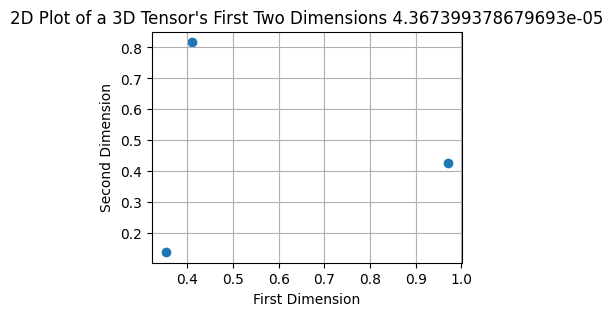

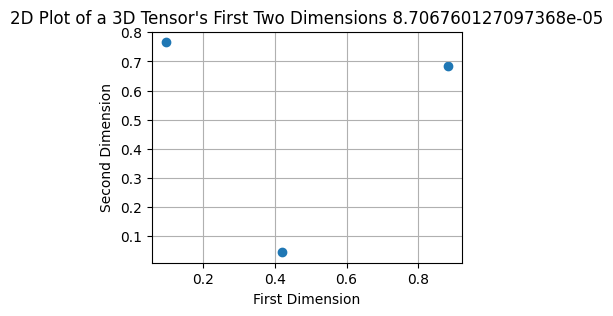

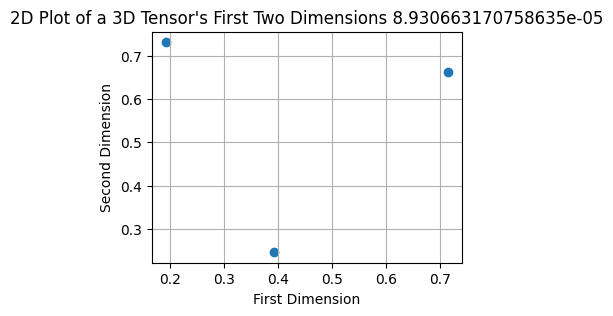

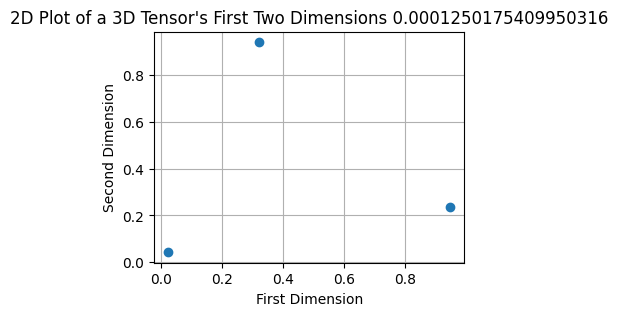

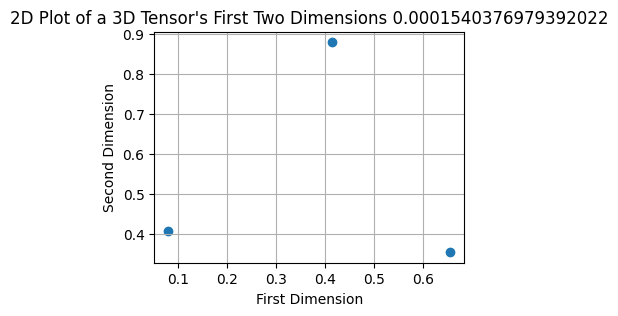

In [41]:
import matplotlib.pyplot as plt
import torch


def plotit(polarslist, label):
    print(label)
    for entry in polarslist.rows()[:5]:
        #tensor = torch.tensor(entry[3])
        # Extract the first two dimensions
        # x = tensor[:, 0].numpy()
        # y = tensor[:, 1].numpy()
        points = entry[1]
        x=[points[0][0],points[1][0], points[2][0]]
        y=[points[0][1],points[1][1], points[2][1]]
        
        # Plot using matplotlib
        plt.figure(figsize=(4, 3))
        plt.scatter(x, y, marker='o')
        plt.title(f"2D Plot of a 3D Tensor's First Two Dimensions {entry[0]}")
        plt.xlabel('First Dimension')
        plt.ylabel('Second Dimension')
        plt.grid(True)
        plt.show()

#plotit(resultdf.sort("one"), "ONE")
plotit(resultdf.sort("score"), "TWO")

In [33]:
resultdf.sort("column_1")[4]['column_0'].item()

'[44.42523193359375, 51.853336334228516, 52.05618667602539, 54.51387023925781, 55.29835510253906, 58.44028091430664, 59.205284118652344, 60.085968017578125, 66.26136779785156, 68.06070709228516, 73.42994689941406, 76.3694839477539]'